In [2]:
# Standard imports
import math
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import os

### Load in audio files

In [4]:
# Load audio into librosa
debussy_file = os.path.join("audio", "debussy.wav")
redhot_file = os.path.join("audio", "redhot.wav")

debussy, sr = librosa.load(path=debussy_file)
redhot, _ = librosa.load(path=redhot_file)

### Extract spectrograms

In [11]:
# Constants
FRAME_SIZE = 2048
HOP_SIZE = 512

# Extract spectrograms
debussy_spec = librosa.stft(
    debussy, 
    n_fft=FRAME_SIZE, 
    hop_length=HOP_SIZE
)

redhot_spec = librosa.stft(
    redhot, 
    n_fft=FRAME_SIZE, 
    hop_length=HOP_SIZE
)

# Discard the phase information
debussy_spec = np.abs(debussy_spec)
redhot_spec = np.abs(redhot_spec)

### Implement Band Energy Ratio (BER) from scratch

In [18]:
def calculate_frequency_bin(n_bins: int, sr: int, f: int) -> int:
    """
    Calculates the corresponding frequency bin in a spectrogram
    for a given frequency in Hz

    Arguments
    ---------
    - n_bins : (int)
        - Total number of frequency bins
    - sr : (int)
        - Sampling rate (in Hz)
    - f : (int)
        - Frequency to convert (in Hz)
    
    Returns
    -------
    - bin : (int)
        - The corresponding frequency bin for the given frequency
    """
    freq_range = sr / 2 # Since the STFT ranges up to the Nyquist frequency
    freq_per_bin = freq_range / n_bins
    freq_bin = int(f / freq_per_bin)
    return freq_bin

def calculate_ber(split_bin: int, Y: np.ndarray) -> np.ndarray:
    """
    Calculates the Band Energy Ratios (BERs) of a signal 
    at every frame

    Arguments
    ---------
    - split_bin : int
        - Split frequency bin
    - Y : np.ndarray [shape=(# of frequency bins, # of frames)]
        - Spectrogram of signal obtained from Short-Time Fourier Transform

    Returns
    -------
    - bers : np.ndarray [shape=(# of frames, )]
        - The ratio of the total energy in the lower frequencies to
        the total energy in the higher frequencies
    """
    power_spec = np.square(Y)
    power_spec = power_spec.T

    bers = []

    for freqs in power_spec:
        lower_freqs = np.sum(freqs[1:split_bin])
        higher_freqs = np.sum(freqs[split_bin:])
        bers.append(lower_freqs / higher_freqs)

    return np.array(bers)

In [22]:
# Calculate split frequency
split_freq = 2000
split_freq_bin = calculate_frequency_bin(
    n_bins=debussy_spec.shape[0], # will be the same for redhot
    sr=sr,
    f=split_freq
    )

debussy_bers = calculate_ber(split_bin=split_freq_bin, Y=debussy_spec)
redhot_bers = calculate_ber(split_bin=split_freq_bin, Y=redhot_spec)
print(f"First 5 Debussy BERs at f={split_freq_bin}:\n{debussy_bers[:5]}")

First 5 Debussy BERs at f=185:
[ 58.258842  56.340656  89.70827  198.19052  379.6269  ]


### Visualize BER curves

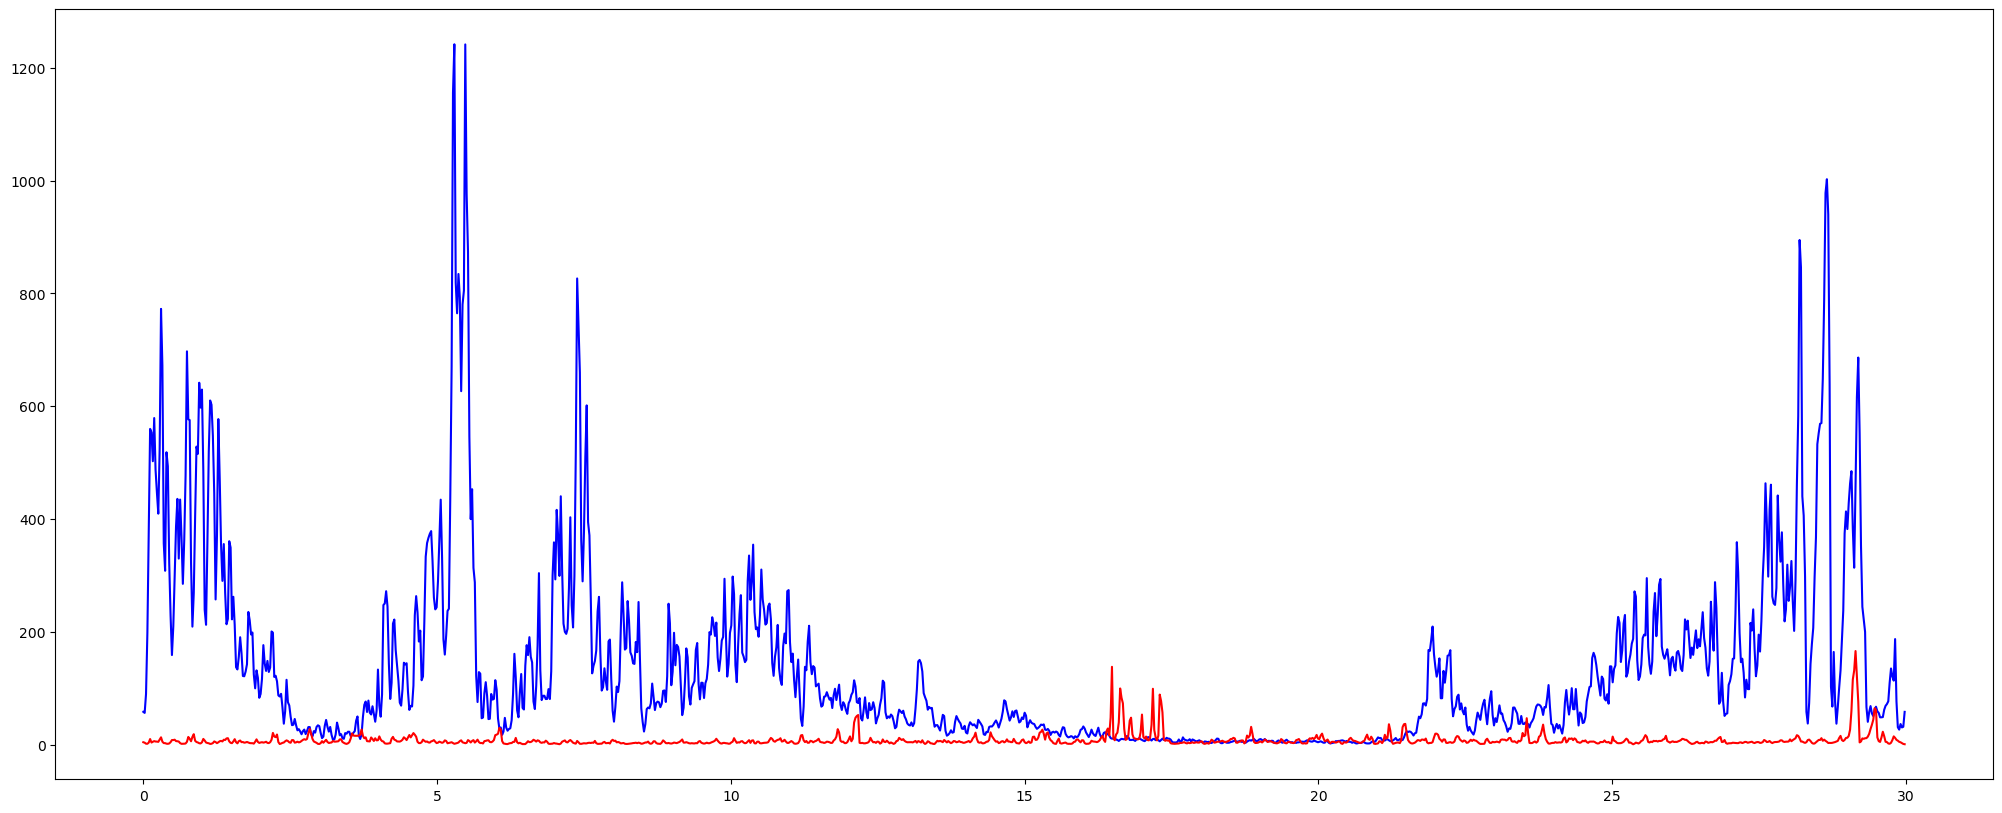

In [23]:
# Convert frames to time stamps
frames = np.arange(stop=debussy_bers.shape[0])
t = librosa.frames_to_time(frames=frames, hop_length=HOP_SIZE)

plt.figure(figsize=(25, 10))

plt.plot(t, debussy_bers, color='b')
plt.plot(t, redhot_bers, color='r')

plt.show()

A higher ratio means that there is more energy in the lower frequencies, and a lower ratio means that there is more energy in the higher frequencies